In [1]:
import numpy as np
import pandas as pd
import os
import random
import time
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from Utils.metrics import rmse_metric
from Modelos.generator import Generator
from Modelos.discriminator import Discriminator

from PIL import Image

/home/pablodonav/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/pablodonav/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# number of epochs of training
n_epochs = 20

crop_size = 256

# name of the dataset
dataset_path = "data/"

# adam: learning rate
lr = 1e-4

# epoch from which to start lr decay
decay_epoch = 100

# number of cpu threads to use during batch generation
n_cpu = 8

# high res. image height
hr_height = 1024

# high res. image width
hr_width = 1024

# number of image channels
channels = 1

checkpoint_interval = 5000
sample_interval = 100

hr_shape = (hr_height, hr_width)

os.makedirs("images/validation", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ImageDataset(Dataset):
    def __init__(self, files, hr_shape, mapping=False):

        self.files = [os.path.join(files, f) for f in sorted(os.listdir(files))]

        hr_height, hr_width = hr_shape
        self.mapping = mapping

        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_width // 4)),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_width)),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
            ]
        )
        self.lr_transform_mapping = transforms.Compose(
            [
                transforms.RandomResizedCrop(crop_size // 4),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
            ]
        )
        self.hr_transform_mapping = transforms.Compose(
            [
                transforms.RandomResizedCrop(crop_size),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
            ]
        )

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        if self.mapping:
            img_lr = self.lr_transform_mapping(img)
            img_hr = self.hr_transform_mapping(img)
        else:
            img_lr = self.lr_transform(img)
            img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [4]:
train_paths = dataset_path + 'Chest_X-Ray_train_HR/'
valid_paths = dataset_path + 'Chest_X-Ray_valid_HR/'
train_dataset = ImageDataset(train_paths, hr_shape=hr_shape, mapping=False)
valid_dataset = ImageDataset(valid_paths, hr_shape=hr_shape, mapping=False)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        # Convertir la imagen monocromática en RGB de 3 canales
        img_rgb = torch.cat([img, img, img], dim=1)
        return self.feature_extractor(img_rgb)


In [6]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator(input_shape=(channels, *hr_shape)).to(device)
feature_extractor = FeatureExtractor().to(device)

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)
criterion_content = torch.nn.MSELoss().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

/home/pablodonav/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/pablodonav/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def train_step(lr, hr):

    optimizer_G.zero_grad()

    # Generate a high resolution image from low resolution input
    gen_hr = generator(lr)

    gen_features = feature_extractor(gen_hr)
    real_features = feature_extractor(hr).detach()
    mse = criterion_content(real_features, gen_features)
    
    gen_loss = criterion_GAN(gen_hr, torch.ones_like(gen_hr)) # Generator Loss
    
    perc_loss = mse + 0.001 * gen_loss # Total generator loss

    perc_loss.backward()
    optimizer_G.step()

    optimizer_D.zero_grad()

    pred_real = discriminator(hr)
    pred_fake = discriminator(gen_hr.detach())

    loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
    loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
    disc_loss = loss_real + loss_fake

    disc_loss.backward()
    optimizer_D.step()

    return perc_loss, disc_loss

In [8]:
gen_loss_array = np.array([])
disc_loss_array = np.array([])
rmse_error_array = np.array([])
time_array = np.array([])

start_time = time.time()

for epoch in range(n_epochs):

    # ----------
    #  Training
    # ----------
    gen_loss, disc_loss = 0, 0
    
    for i, imgs in enumerate(train_dataloader):
        
        batches_done = epoch * len(train_dataloader) + i
        
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        
        perceptual_loss, discriminator_loss = train_step(imgs_lr, imgs_hr)
        
        if batches_done % sample_interval == 0:
            # Evaluate on validation set
            generator.eval()  # Set generator to evaluation mode
            val_gen_loss = 0
            with torch.no_grad():
                for j, imgs_val in enumerate(valid_dataloader):
                    filename = valid_dataset.files[j % len(valid_dataset.files)]
                    if filename == 'data/Chest_X-Ray_valid_HR/10.jpeg':
                        val_lr = Variable(imgs_val["lr"].type(Tensor))
                        val_hr = Variable(imgs_val["hr"].type(Tensor))
                        break

                # Generate a high resolution image from low resolution input
                gen_hr = generator(val_lr)

                gen_hr = gen_hr.squeeze()
                gen_hr = (gen_hr - gen_hr.min()) / (gen_hr.max() - gen_hr.min())    # Escala de 0 a 1
                gen_hr = (gen_hr * 255).clamp(0, 255).to(torch.uint8)               # Escala de 0 a 255

                imagen_gen_hr = Image.fromarray(gen_hr.cpu().numpy(), mode='L')
                imagen_gen_hr.save("images/validation/%d.jpeg" % batches_done)

                if batches_done == 0:

                    val_lr = val_lr.squeeze()
                    val_lr = (val_lr - val_lr.min()) / (val_lr.max() - val_lr.min())    # Escala de 0 a 1
                    val_lr = (val_lr * 255).clamp(0, 255).to(torch.uint8)               # Escala de 0 a 255        

                    val_hr = val_hr.squeeze()
                    val_hr = (val_hr - val_hr.min()) / (val_hr.max() - val_hr.min())    # Escala de 0 a 1
                    val_hr = (val_hr * 255).clamp(0, 255).to(torch.uint8)               # Escala de 0 a 255
                    
                    imagen_val_lr = Image.fromarray(val_lr.cpu().numpy(), mode='L')
                    imagen_val_lr.save("images/validation/low_res_image.jpeg")
                    
                    imagen_val_hr = Image.fromarray(val_hr.cpu().numpy(), mode='L')
                    imagen_val_hr.save("images/validation/high_res_image.jpeg")
                
            rmse = rmse_metric(imagen_gen_hr, imagen_val_hr)
            
            train_time = time.time()
            
            rmse_error_array = np.append(rmse_error_array, rmse)
            disc_loss_array = np.append(disc_loss_array, discriminator_loss.cpu().detach().numpy())
            gen_loss_array = np.append(gen_loss_array, np.multiply(perceptual_loss.cpu().detach().numpy(), 100))
            current_time = train_time - start_time
            time_array = np.append(time_array, current_time)
            
            generator.train()  # Set generator back to training mode
            
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [RMSE: %f] (%f s)"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    discriminator_loss.item(),
                    np.multiply(perceptual_loss.item(), 100),
                    rmse,
                    current_time
                )
            )

        if batches_done % checkpoint_interval == 0:
            # Save model checkpoints
            torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
            torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" %epoch)

[Epoch 0/20] [Batch 0/3188] [D loss: 1.436270] [G loss: 218.764496] [RMSE: 0.315577] (1.852360 s)
[Epoch 0/20] [Batch 100/3188] [D loss: 1.023175] [G loss: 42.710787] [RMSE: 0.265842] (45.111354 s)
[Epoch 0/20] [Batch 200/3188] [D loss: 1.020009] [G loss: 35.157040] [RMSE: 0.254905] (88.131244 s)
[Epoch 0/20] [Batch 300/3188] [D loss: 1.019233] [G loss: 27.055466] [RMSE: 0.254032] (131.340022 s)
[Epoch 0/20] [Batch 400/3188] [D loss: 1.018913] [G loss: 29.757592] [RMSE: 0.253680] (174.508641 s)
[Epoch 0/20] [Batch 500/3188] [D loss: 1.018687] [G loss: 32.121256] [RMSE: 0.257936] (217.581411 s)
[Epoch 0/20] [Batch 600/3188] [D loss: 1.018747] [G loss: 18.707600] [RMSE: 0.216536] (260.876720 s)
[Epoch 0/20] [Batch 700/3188] [D loss: 1.018525] [G loss: 14.198913] [RMSE: 0.256314] (303.929218 s)
[Epoch 0/20] [Batch 800/3188] [D loss: 1.018478] [G loss: 13.107181] [RMSE: 0.210866] (347.106504 s)
[Epoch 0/20] [Batch 900/3188] [D loss: 1.018435] [G loss: 14.950348] [RMSE: 0.219631] (390.16709

Traceback (most recent call last):
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-3x4wroxr'


[Epoch 7/20] [Batch 1384/3188] [D loss: 1.006411] [G loss: 4.790700] [RMSE: 0.118848] (9487.393130 s)
[Epoch 7/20] [Batch 1484/3188] [D loss: 1.006473] [G loss: 4.702015] [RMSE: 0.121521] (9527.245486 s)
[Epoch 7/20] [Batch 1584/3188] [D loss: 1.006411] [G loss: 3.003513] [RMSE: 0.108347] (9567.093588 s)
[Epoch 7/20] [Batch 1684/3188] [D loss: 1.006418] [G loss: 14.272650] [RMSE: 0.114180] (9606.945078 s)
[Epoch 7/20] [Batch 1784/3188] [D loss: 1.006411] [G loss: 7.184244] [RMSE: 0.097324] (9646.810573 s)
[Epoch 7/20] [Batch 1884/3188] [D loss: 1.006410] [G loss: 5.785794] [RMSE: 0.111845] (9686.658332 s)
[Epoch 7/20] [Batch 1984/3188] [D loss: 1.006410] [G loss: 3.778656] [RMSE: 0.119187] (9726.508375 s)
[Epoch 7/20] [Batch 2084/3188] [D loss: 1.006410] [G loss: 16.789024] [RMSE: 0.116885] (9766.350572 s)
[Epoch 7/20] [Batch 2184/3188] [D loss: 1.006410] [G loss: 9.629679] [RMSE: 0.095232] (9806.202575 s)
[Epoch 7/20] [Batch 2284/3188] [D loss: 1.006410] [G loss: 4.437245] [RMSE: 0.13

Traceback (most recent call last):
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/pablodonav/miniconda3/envs/torch/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-k47t29ca'


[Epoch 8/20] [Batch 396/3188] [D loss: 1.006412] [G loss: 7.179582] [RMSE: 0.120828] (10364.281935 s)
[Epoch 8/20] [Batch 496/3188] [D loss: 1.006411] [G loss: 2.903072] [RMSE: 0.100586] (10404.136462 s)
[Epoch 8/20] [Batch 596/3188] [D loss: 1.006413] [G loss: 5.504420] [RMSE: 0.093520] (10443.980564 s)
[Epoch 8/20] [Batch 696/3188] [D loss: 1.006410] [G loss: 12.037599] [RMSE: 0.108355] (10483.845867 s)
[Epoch 8/20] [Batch 796/3188] [D loss: 1.006410] [G loss: 7.845789] [RMSE: 0.095540] (10523.693252 s)
[Epoch 8/20] [Batch 896/3188] [D loss: 1.006410] [G loss: 3.317349] [RMSE: 0.102768] (10563.543276 s)
[Epoch 8/20] [Batch 996/3188] [D loss: 1.006411] [G loss: 5.686914] [RMSE: 0.111305] (10603.392687 s)
[Epoch 8/20] [Batch 1096/3188] [D loss: 1.006409] [G loss: 5.922117] [RMSE: 0.114646] (10643.242076 s)
[Epoch 8/20] [Batch 1196/3188] [D loss: 1.006414] [G loss: 5.044375] [RMSE: 0.087533] (10683.095229 s)
[Epoch 8/20] [Batch 1296/3188] [D loss: 1.006414] [G loss: 3.338014] [RMSE: 0.1

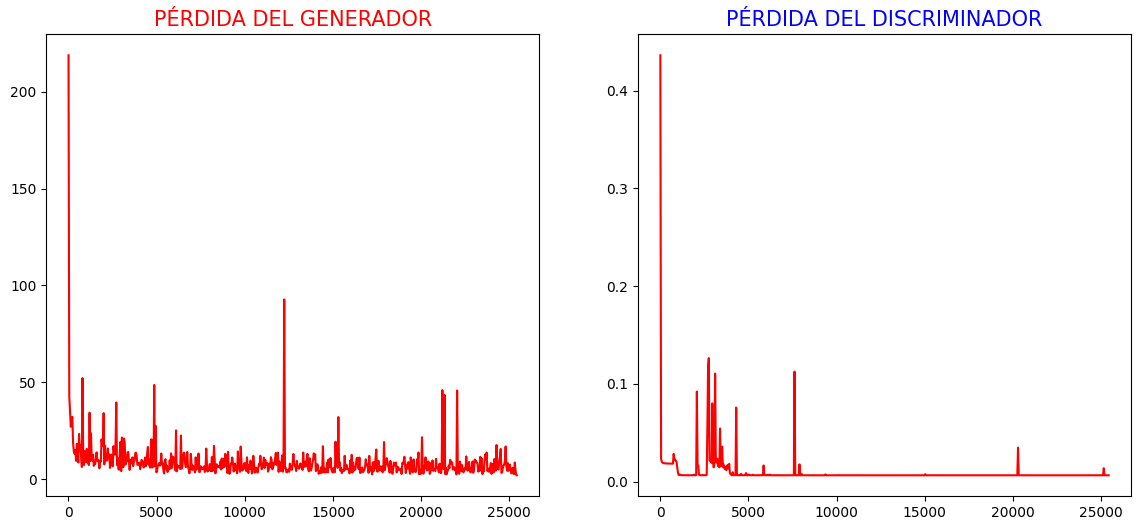

In [13]:
f, ax= plt.subplots(1,2, figsize=(14, 6))
losses = [gen_loss_array, disc_loss_array]
titles = ['PÉRDIDA DEL GENERADOR', 'PÉRDIDA DEL DISCRIMINADOR']
colors = ['r', 'b']

for c in range(2):
  ax[c].plot(time_array, losses[c], color='r')
  ax[c].set_title(titles[c], color=colors[c], fontsize=15)

Text(0.5, 1.0, 'RMSE')

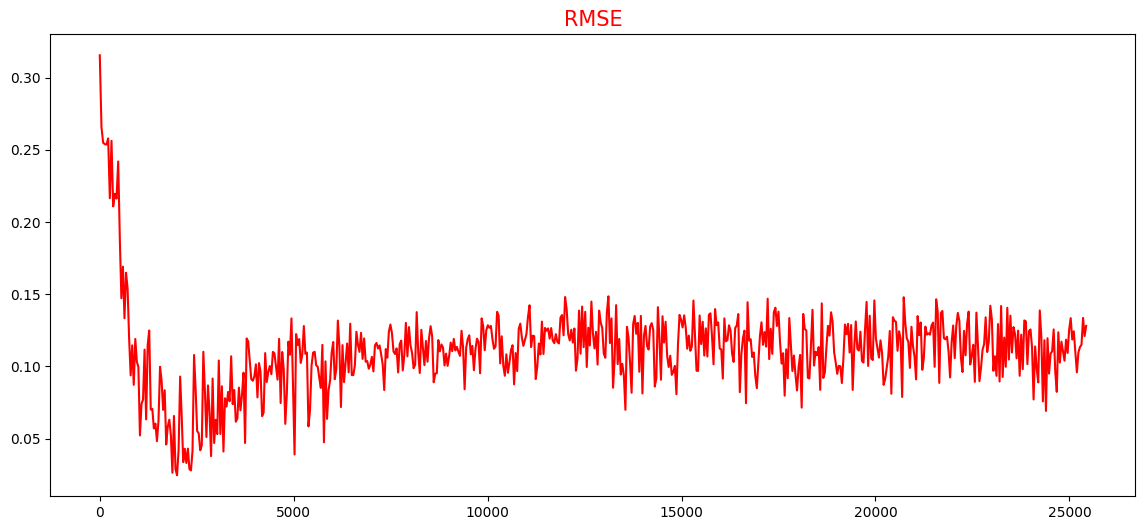

In [10]:
f, ax= plt.subplots(1,1, figsize=(14, 6))
metrics = rmse_error_array
titles = 'RMSE'
colors = 'r'

ax.plot(time_array, rmse_error_array, color='r')
ax.set_title(titles, color=colors, fontsize=15)

In [14]:
data = {
    'Time': time_array,
    'RMSE Error': rmse_error_array,
    'Generator Loss': gen_loss_array,
    'Discriminator Loss': disc_loss_array
}

df = pd.DataFrame(data)
df.to_csv('metrics_pytorch.csv', index=False)